In [1]:
# Setting up pyplot runtime configuration

from matplotlib.ticker import MaxNLocator

SMALL = 10
MEDIUM = 14
LARGE = 20
THICK = 4
THIN = 3
WIDE_FIG = (20,6)


plt.style.context('fivethirtyeight')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='black', axisbelow=True, grid=True)
plt.rc('grid', color='white', linestyle='solid')
plt.rc('lines', linewidth=THICK)

plt.rc('font', size=SMALL, weight='bold')          # default text sizes
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM)    # legend fontsize
plt.rc('figure', titlesize=LARGE)  # fontsize of the figure title

COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from utils import *
from ols import *
from ridge import *
from lasso import *

/home/olav/anaconda3/envs/fys-stk4155/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 5
VAR_EPS = .03
polynomial_orders = list(range(MAX_POLY_ORDER+1))

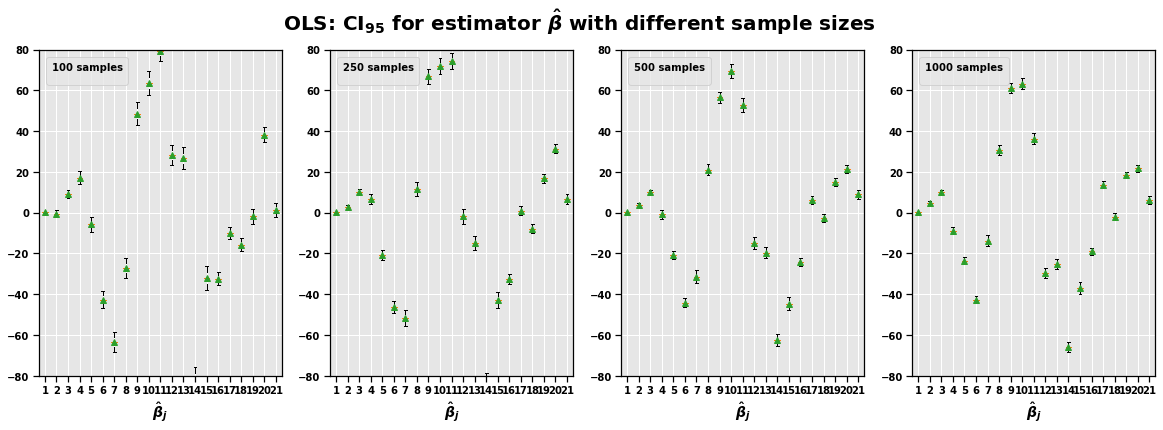

In [4]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS: CI$_{95}$ for estimator $\hat{\beta}$ with different sample sizes", fontsize=LARGE, weight='bold')
ylim = (-80,80)

scaler = skl.preprocessing.StandardScaler(with_std=False)
plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    X_down = scaler.fit_transform(X_down)
    X_down[:,0] = 1
    plt.boxplot(beta_hat_confidence_intervals(X_down, z_down, VAR_EPS, ci=95), showbox=False, showmeans=True)
    plt.ylim(*ylim)
    plt.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    plt.xlabel(r"$\hat{\beta}_j$")

plt.show()

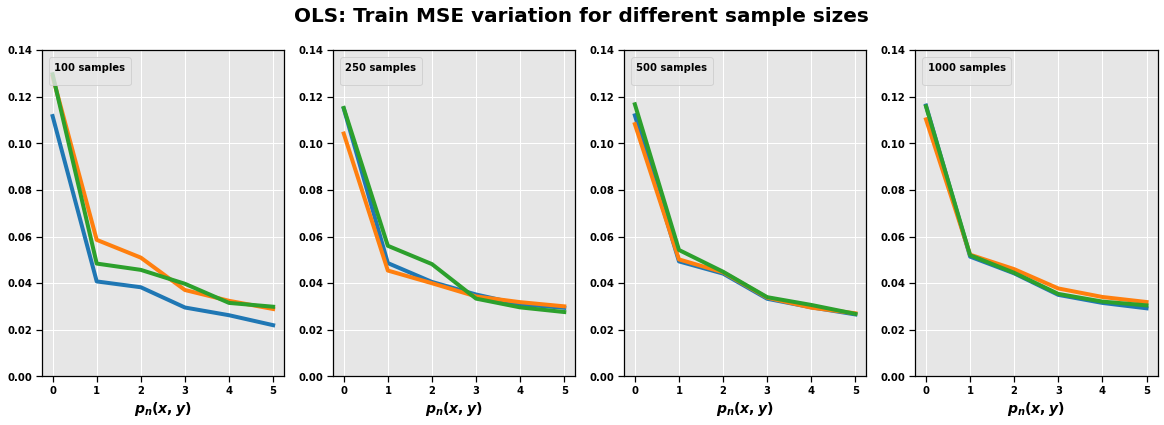

In [5]:
plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS: Train MSE variation for different sample sizes", fontsize=LARGE, weight='bold')
ylim = (0,.14)

scaler = skl.preprocessing.StandardScaler(with_std=False)
plots = [141,142,143,144]
samples = [100,250,500,1000]
ols_mse = np.ndarray(len(polynomial_orders))

random_state = 0
for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    for i in range(3):
        x, y = randmesh(sn=sn, random_state=i)
        X = make_design_matrix(x, y, pn=5)
        z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)
        for pn in polynomial_orders:
            Xpn = truncate_to_poly(X, pn)
            Xpn = scaler.fit_transform(Xpn)
            Xpn[:,0] = 1
            beta_hat = np.linalg.inv(Xpn.T @ Xpn) @ Xpn.T @ z
            z_tilde = Xpn @ beta_hat
            ols_mse[pn] = mse(z, z_tilde)
        plt.plot(polynomial_orders, ols_mse)
    plt.ylim(*ylim)
    plt.legend([], title=f'{sn} samples', title_fontsize=SMALL, loc='upper left')
    plt.xlabel(r"$p_n(x,y)$")

plt.show()

In [6]:
NUM_SAMPLES = 1000
MAX_POLY_ORDER = 15
VAR_EPS = .015
polynomial_orders = list(range(MAX_POLY_ORDER+1))

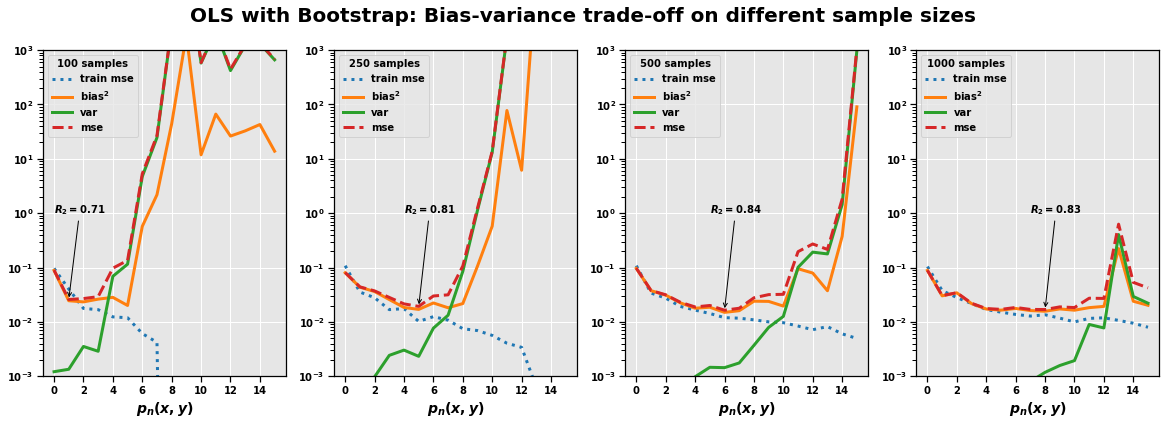

In [7]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS with Bootstrap: Bias-variance trade-off on different sample sizes", fontsize=LARGE, weight='bold')
ylim = (1E-3, 1E3)

plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    f_down = f[:sn]
    ols_bs_df = run_ols_bootstrap(X_down, z_down, f_down, polynomial_orders=polynomial_orders, train_size=.7, bootstraps=25)
    plt.plot(polynomial_orders, ols_bs_df['train_mse'], ':', linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_bias'], linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_var'], linewidth=THIN)
    plt.plot(polynomial_orders, ols_bs_df['test_mse'], '--', linewidth=THIN)
    plt.legend(['train mse', 'bias$^2$', 'var', 'mse'], title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    plt.ylim(*ylim)
    plt.xlabel(r"$p_n(x,y)$")
    plt.yscale('log')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_bs_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_bs_df['test_mse'].min()
    xytext = (best_mse_pn-1, 1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_bs_df['test_mse'], z_down)
    plt.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

plt.show()

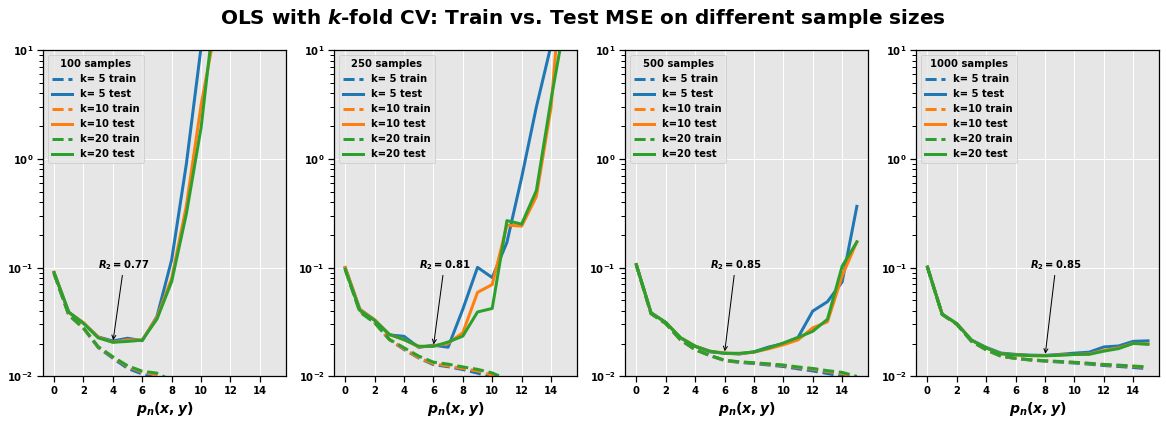

In [22]:
x, y = randmesh(sn=NUM_SAMPLES)
X = make_design_matrix(x, y, pn=MAX_POLY_ORDER)
z, f, _ = franke_sampler(x.T[0], y.T[0], var_eps=VAR_EPS)

plt.figure(figsize=WIDE_FIG)
plt.suptitle(r"OLS with $k$-fold CV: Train vs. Test MSE on different sample sizes", fontsize=LARGE, weight='bold')
ylim = (1E-2, 1E1)

plots = [141,142,143,144]
samples = [100,250,500,1000]

for plot, sn in zip(plots, samples):
    plt.subplot(plot)
    X_down = X[:sn]
    z_down = z[:sn]
    legend = []
    for i, k in enumerate([5,10,20]):
        ols_k_df = run_ols_kfold(X_down, z_down, k=k, polynomial_orders=polynomial_orders)
        plt.plot(polynomial_orders, ols_k_df['train_mse'], '--', linewidth=THIN, color=COLORS[i])
        plt.plot(polynomial_orders, ols_k_df['test_mse'], linewidth=THIN, color=COLORS[i])
        legend += [f'k={k:2d} train', f'k={k:2d} test']
    plt.legend(legend, title=f'{sn} samples', fontsize=SMALL, title_fontsize=SMALL, loc='upper left')
    plt.ylim(*ylim)
    plt.xlabel(r"$p_n(x,y)$")
    plt.yscale('log')
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # R2 annotation 
    best_idx = ols_k_df['test_mse'].argmin()
    best_mse_pn = polynomial_orders[best_idx]
    best_mse_val = ols_k_df['test_mse'].min()
    xytext = (best_mse_pn-1, .1)
    xy = (best_mse_pn, best_mse_val)
    R2 = best_r2(ols_k_df['test_mse'], z_down)
    plt.annotate(f'$R_2 = {R2:.2f}$', xytext=xytext, xy=xy, arrowprops={'arrowstyle':'->'})

plt.show()